In [1]:
import os
import pandas as pd
data_path = 'ml-20m/'
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [2]:
df_movies.head()
df_movies.shape


(27278, 2)

In [3]:
df_ratings.head()


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [4]:
df_ratings=df_ratings[:2000000]

In [5]:
df_ratings.shape

(2000000, 3)

In [6]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [7]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [8]:
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,13558,13559,13560,13561,13562,13563,13564,13565,13566,13567
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,3.0,4.0,0.0,2.0,4.0,0.0,5.0,4.5,0.0,0.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [10]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 13567 unique users and 16715 unique movies in this data set


In [11]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,23427
1.0,68420
1.5,27518
2.0,146105
2.5,89328
3.0,432669
3.5,217863
4.0,557816
4.5,151291


In [12]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,224772405
0.5,23427
1.0,68420
1.5,27518
2.0,146105
2.5,89328
3.0,432669
3.5,217863
4.0,557816
4.5,151291


In [13]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,224772405,19.230599
0.5,23427,10.061644
1.0,68420,11.133420
1.5,27518,10.222596
2.0,146105,11.892081
2.5,89328,11.400070
3.0,432669,12.977728
3.5,217863,12.291622
4.0,557816,13.231784
4.5,151291,11.926960


Text(0, 0.5, 'number of ratings')

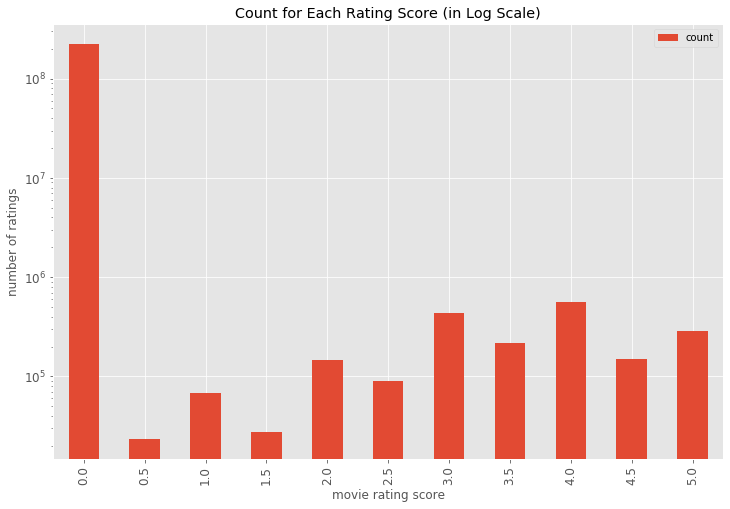

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [16]:
# get rating frequency
#number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,4883
2,2209
3,1256
4,272
5,1227


In [17]:
#now we need to take only movies that have been rated atleast 50 times to get some idea of the reactions of users towards it

popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping unpopular movies:  (1876209, 3)


In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,166
2,58
3,187
4,28
5,66


In [19]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (1712154, 3)


In [20]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [21]:
movie_user_mat_sparse

<4525x8276 sparse matrix of type '<class 'numpy.float32'>'
	with 1712154 stored elements in Compressed Sparse Row format>

In [22]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [23]:
from fuzzywuzzy import fuzz

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [25]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: movie-user matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [36]:
my_favorite = '(2012)'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=20)

You have input movie: (2012)
Found possible matches in our database: ['Mud (2012)', 'Ted (2012)', 'Argo (2012)', 'O (2001)', 'Dredd (2012)', 'Brave (2012)', 'Flight (2012)', 'Looper (2012)', 'Her (2013)', 'Rio (2011)', 'Red (2010)', 'Wit (2001)', 'May (2002)', 'xXx (2002)', 'Ali (2001)', 'Lincoln (2012)', 'Skyfall (2012)']

Recommendation system start to make inference
......

Recommendations for (2012):
1: Ides of March, The (2011), with distance of 0.7426026463508606
2: Hunt, The (Jagten) (2012), with distance of 0.7405677437782288
3: Django Unchained (2012), with distance of 0.740519106388092
4: Life of Pi (2012), with distance of 0.7364919185638428
5: Drive (2011), with distance of 0.7291691899299622
6: Perks of Being a Wallflower, The (2012), with distance of 0.7273563146591187
7: Moonrise Kingdom (2012), with distance of 0.7238425016403198
8: End of Watch (2012), with distance of 0.7154861688613892
9: Gone Girl (2014), with distance of 0.7110567688941956
10: Argo (2012), with dis

In [27]:
movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Othello (1995)': 25,
 'Now and Then (1995)': 26,
 'Persuasion (1995)': 27,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29,
 'Dangerous Minds (1995)': 30,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 